In [2]:
!gdown --id "1Z748ksOFWZ8WLsy0P8T7eYA6XLVLieX3&export=download"
!unrar x -Y "/Users/ngocanh/Downloads/Lab/CTAI-ML/ML-exercises/Ex17/lab2.rar" -d "/content/"

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Z748ksOFWZ8WLsy0P8T7eYA6XLVLieX3&export=download
To: /Users/ngocanh/Ex17/lab2.rar
100%|██████████████████████████████████████████| 599/599 [00:00<00:00, 1.20MB/s]
zsh:1: command not found: unrar


In [3]:
import torch
import torch.nn as nn
import numpy as np
import networkx as nx
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd

In [14]:
def create_graphs_with_attributes(edgelist_filepath,attributes_filepath):
    graph = nx.read_edgelist(edgelist_filepath,nodetype = int)
    attributes = pd.read_csv(attributes_filepath,index_col = ['node'])
    att_values = {a:{'role':b[0],'community':b[1]} for a,b in enumerate(attributes.values)}
    nx.set_node_attributes(graph,att_values)
    return graph


def create_train_test(graph):
    X_train,Y_train,X_test,Y_test = [],[],[],[]
    for node, data in graph.nodes(data = True):
        if data['role'] in ['Administrator','Instructor']:
            X_train.append(node)
            Y_train.append(data['role'] == 'Administrator')
        elif data['role'] =='Member':
            X_test.append(node)
            Y_test.append(data['community'] == 'Administrator')
    return np.asarray(X_train),np.asarray(Y_train),np.asarray(X_test),np.asarray(Y_test)



def create_features(graph): # create input features, concatenation of identity matrix and shortest paths to targets
    A = nx.to_numpy_array(graph)
    X_1 = torch.eye(A.shape[0]) # identity matrix
    X_2 = torch.zeros((A.shape[0], 2)) # shortest path to the targets as 2nd input feature
    node_distance_instructor = nx.shortest_path_length(graph, target = 33)
    node_distance_administrator = nx.shortest_path_length(graph, target = 0)

    for node in graph.nodes():
        X_2[node][0] = node_distance_administrator[node]
        X_2[node][1] = node_distance_instructor[node]

    return torch.cat((X_1,X_2),dim = 1)    

In [15]:
from torch.nn.parameter import Parameter

class GCN_layer(nn.Module):
    """
      Define filter layer 1/2 like in the above image
      Calculate A_hat first then,
      Input: adj_matrix with input features X
    """   

    def __init__(self, inputs_shape, outputs_shape):
        super(GCN_layer, self).__init__()

        self.W=Parameter(torch.rand(inputs_shape,outputs_shape),requires_grad=True)
        self.bias = Parameter(torch.rand(outputs_shape),requires_grad=True)

    
    def forward(self, adj_matrix, input_features):
        A = torch.from_numpy(adj_matrix).type(torch.LongTensor)
        I = torch.eye(A.shape[0])   
        A_hat = A+I        
        D = torch.sum(A_hat,axis = 0)        
        D = torch.diag(D)       
        D_inv = torch.inverse(D)              
        A_hat = torch.mm(torch.mm(D_inv,A_hat),D_inv)     
        aggregate = torch.mm(A_hat,input_features)      
        propagate = torch.mm(aggregate,self.W)+self.bias             
        return propagate

In [16]:
class GCN(nn.Module):
    

    def __init__(self,inputs_shape,outputs_shape,n_classes,activation='Relu'):
        super(GCN, self).__init__()

        self.layer1 = GCN_layer(inputs_shape,outputs_shape)
        self.layer2 = GCN_layer(outputs_shape,n_classes)
        
        
        if activation =='Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'Softmax':
            self.activation = nn.Softmax()
        elif activation == 'Relu':
            self.activation = nn.ReLU()
    
        self.softmax = nn.Softmax()
        
    
    def forward(self,adj_matrix,input_features):
        
        x = self.layer1(adj_matrix,input_features)
        x = self.activation(x) 
        x = self.layer2(adj_matrix,x)
        x = self.softmax(x)     
        
        return x

In [17]:
import torch
from sklearn.metrics import classification_report
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import networkx as nx


graph = create_graphs_with_attributes('lab2_edgelist.txt', 'lab2_attributes.csv')
A = nx.to_numpy_array(graph) # adjadjency matrix

class Trainer():
    def __init__(self,model,optimizer,loss_function,epochs):
        
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.epochs = epochs
        
    def train(self,X_train,Y_train):

        y_train = torch.from_numpy(Y_train.astype(int)).type(torch.LongTensor)
        tot_loss = 0.0
        all_preds = []

        for t in range(self.epochs):
            epoch_loss = 0.0

            #model.train()
            y_pred = self.model(A, create_features(graph))
            all_preds.append(y_pred)
            loss = self.loss_function(y_pred[X_train], y_train)
            self.optimizer.zero_grad()
            epoch_loss += loss
            tot_loss += loss
            loss.backward()
            self.optimizer.step()

            print(str(t), 'epoch_loss:' + str(epoch_loss), 'total loss:' + str(tot_loss))

        self.all_preds = all_preds
    
    def test(self,X_test,Y_test):

        self.model.eval()
        y_test = torch.from_numpy(Y_test.astype(int)).type(torch.LongTensor)
        y_pred = self.all_preds[-1]  # preds of last epoch
        loss_test = self.loss_function(y_pred[X_test],y_test)
        print('validation loss is equal to: ' + str(loss_test))
    
    def visualize_classification(self,graph,Y_test,classification):
        last_epoch = self.all_preds[self.epochs-1].detach().numpy() # get outputs of last epoch
        predicted_class = np.argmax(last_epoch, axis = -1) # take the unit with the higher probability
        color = np.where(predicted_class == 0, 'c', 'r')
        pos = nx.kamada_kawai_layout(graph)
        nx.draw_networkx(graph, pos, node_color = color, with_labels = True, node_size = 300)
        if classification == True:
            print(classification_report(predicted_class[1:-1], Y_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 epoch_loss:tensor(0.7083, grad_fn=<AddBackward0>) total loss:tensor(0.7083, grad_fn=<AddBackward0>)
1 epoch_loss:tensor(0.7067, grad_fn=<AddBackward0>) total loss:tensor(1.4150, grad_fn=<AddBackward0>)
2 epoch_loss:tensor(0.7051, grad_fn=<AddBackward0>) total loss:tensor(2.1201, grad_fn=<AddBackward0>)
3 epoch_loss:tensor(0.7036, grad_fn=<AddBackward0>) total loss:tensor(2.8237, grad_fn=<AddBackward0>)
4 epoch_loss:tensor(0.7020, grad_fn=<AddBackward0>) total loss:tensor(3.5257, grad_fn=<AddBackward0>)
5 epoch_loss:tensor(0.7005, grad_fn=<AddBackward0>) total loss:tensor(4.2263, grad_fn=<AddBackward0>)
6 epoch_loss:tensor(0.6991, grad_fn=<AddBackward0>) total loss:tensor(4.9253, grad_fn=<AddBackward0>)
7 epoch_loss:tensor(0.6976, grad_fn=<AddBackward0>) total loss:tensor(5.6229, grad_fn=<AddBackward0>)
8 epoch_loss:tensor(0.6962, grad_fn=<AddBackward0>) total loss:tensor(6.3191, grad_fn=<AddBackward0>)
9 epoch_loss:tensor(0.6948, grad_fn=<AddBackward0>) total loss:tensor(7.0139, grad

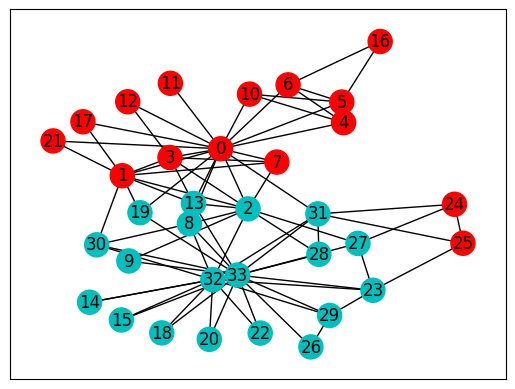

In [18]:
graph = create_graphs_with_attributes('lab2_edgelist.txt','lab2_attributes.csv')
A = nx.to_numpy_array(graph) # adjadjency matrix
X_train,Y_train,X_test,Y_test = create_train_test(graph)

model = GCN(inputs_shape = create_features(graph).shape[1], outputs_shape = 4, n_classes = 2, activation = 'Relu')
trainer = Trainer(
    model,
    optimizer = optim.Adam(model.parameters(), lr = 0.01),
    loss_function = F.cross_entropy,
    epochs = 250
)

trainer.train(X_train,Y_train)
trainer.test(X_test,Y_test)
trainer.visualize_classification(graph,Y_test, classification = True)